In [12]:
from cylib.apis.all_api import *
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## step 1： 数据提取和处理

In [14]:
# 提取一只股票的每日数据
price = get_price(ts_code_list = ['600010.SH'],
                  feature_list=['open','close','low','high','avg_price','adj_close','amount','volume','turn'],
                  start_date = '20140102', trade_date = '20221231')
                #   is_index = False,
                #   is_fund = False)
price = price.reset_index()
price.sort_values('trade_date', inplace = True)
price

,trade_date,ts_code,open,close,low,high,avg_price,adj_close,amount,volume,turn
0,2014-01-02,600010.SH,4.74,4.74,4.74,4.74,4.7400,13.99,117710.0,248332.0,0.3866
1,2014-01-03,600010.SH,5.21,5.21,5.02,5.21,5.1393,15.37,2207680.0,4295680.0,6.6873
2,2014-01-06,600010.SH,5.35,4.90,4.86,5.35,5.0611,14.46,1220570.0,2411650.0,3.7543
3,2014-01-07,600010.SH,4.88,4.78,4.63,4.95,4.7678,14.10,742832.0,1558020.0,2.4254
4,2014-01-08,600010.SH,4.72,4.61,4.56,4.85,4.6899,13.60,529849.0,1129770.0,1.7588
...,...,...,...,...,...,...,...,...,...,...,...
2168,2022-12-26,600010.SH,1.89,1.91,1.89,1.93,1.9114,16.04,272678.0,1426580.0,0.4503
2169,2022-12-27,600010.SH,1.93,1.96,1.92,1.97,1.9421,16.46,450255.0,2318360.0,0.7319
2170,2022-12-28,600010.SH,1.96,1.96,1.95,1.97,1.9620,16.46,321620.0,1639240.0,0.5175
2171,2022-12-29,600010.SH,1.98,1.93,1.92,1.99,1.9461,16.21,470279.0,2416560.0,0.7629


In [16]:
# 选取一个基准
bench_price = get_price(ts_code_list = ['000016.SH'],
                        feature_list = ['close'], start_date='20140102',
                        trade_date = '20221231')
                        # back_len = 10)
                        # is_index = True, is_fund=False)
bench_price.reset_index(inplace=True)
bench_price.sort_values('trade_date', inplace=True)
bench_price

,trade_date,ts_code,close


In [8]:
# 计算每日超额收益率
daily_returns = price['close'].pct_change()
benchmark_returns = bench_price['close'].pct_change()
excess_returns = daily_returns - benchmark_returns
excess_returns

0            NaN
1       0.115190
2      -0.044437
3      -0.022983
4      -0.038663
          ...   
2186   -0.037343
2187    0.008511
2188   -0.024914
2189    0.002714
2190    0.022383
Name: close, Length: 2191, dtype: float64

pct_change() is a method in pandas library that calculates the percentage change between the current and a prior element in a DataFrame or Series. It is commonly used to analyze financial data such as stock prices or economic indicators. This method can be applied to a single column or multiple columns of a DataFrame. It is useful for identifying trends and patterns in the data, and for comparing the performance of different assets over time. The formula for calculating the percentage change is ((current - prior) / prior) * 100.

In [9]:
# 将超额收益转换为二分类问题
excess_returns = excess_returns.apply(lambda x: 1 if x > 0 else 0)
excess_returns = excess_returns.shift(-1)

excess_returns

0       1.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2186    1.0
2187    0.0
2188    1.0
2189    1.0
2190    NaN
Name: close, Length: 2191, dtype: float64

In [10]:
# 表格拼接，删除最后一行
result = pd.concat([price, excess_returns.rename('excess')], axis=1)

result = result.drop(result.index[-1])
result

,trade_date,ts_code,open,close,low,high,avg_price,adj_close,amount,volume,turn,excess
0,2014-01-02,600010.SH,4.74,4.74,4.74,4.74,4.7400,13.99,117710.0,248332.0,0.3866,1.0
1,2014-01-03,600010.SH,5.21,5.21,5.02,5.21,5.1393,15.37,2207680.0,4295680.0,6.6873,0.0
2,2014-01-06,600010.SH,5.35,4.90,4.86,5.35,5.0611,14.46,1220570.0,2411650.0,3.7543,0.0
3,2014-01-07,600010.SH,4.88,4.78,4.63,4.95,4.7678,14.10,742832.0,1558020.0,2.4254,0.0
4,2014-01-08,600010.SH,4.72,4.61,4.56,4.85,4.6899,13.60,529849.0,1129770.0,1.7588,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2019-07-01,600010.SH,1.71,1.71,1.69,1.72,1.7064,14.16,462342.0,2709390.0,0.8553,0.0
2186,2019-08-01,600010.SH,1.57,1.56,1.56,1.58,1.5672,13.00,139076.0,887440.0,0.2802,1.0
2187,2019-11-01,600010.SH,1.36,1.37,1.33,1.38,1.3602,11.42,214390.0,1576170.0,0.4976,0.0
2188,2020-04-01,600010.SH,1.15,1.14,1.14,1.16,1.1451,9.50,181630.0,1586160.0,0.5007,1.0


## step 2： 特征选择

In [11]:
def select_feature(result):
    # X --- 因子矩阵
    # y --- 超额收益率

    X = result.iloc[:, 2:-1]
    y = result.iloc[:,-1]
    
    # 利用方差分析中的 F值来进行特征选择
    # from sklearn.feature_selection import f_classif

    # 计算每个特征与标签之间的F值和p-value
    f_values, p_values = f_classif(X, y)


    # 根据F值进行排序，选择关联度较高的前k个特征

    k = 5  # 设定要选择前k个特征
    top_k_indices = np.argsort(f_values)[-k:]  # 返回最大k个F值对应索引
    print(top_k_indices)

    selected_features = X.iloc[:, top_k_indices]  # 提取选中的特征数据
    selected_features

In [12]:
# X --- 因子矩阵
# y --- 超额收益率

X = result.iloc[:, 2:-1]
y = result.iloc[:,-1]

In [13]:
# 利用方差分析中的 F值来进行特征选择

# 计算每个特征与标签之间的F值和p-value
f_values, p_values = f_classif(X, y)


# 根据F值进行排序，选择关联度较高的前k个特征

k = 5  # 设定要选择前k个特征
top_k_indices = np.argsort(f_values)[-k:]  # 返回最大k个F值对应索引
print(top_k_indices)

selected_features = X.iloc[:, top_k_indices]  # 提取选中的特征数据
selected_features

[1 2 6 8 7]


,close,low,amount,turn,volume
0,4.74,4.74,117710.0,0.3866,248332.0
1,5.21,5.02,2207680.0,6.6873,4295680.0
2,4.90,4.86,1220570.0,3.7543,2411650.0
3,4.78,4.63,742832.0,2.4254,1558020.0
4,4.61,4.56,529849.0,1.7588,1129770.0
...,...,...,...,...,...
2185,1.71,1.69,462342.0,0.8553,2709390.0
2186,1.56,1.56,139076.0,0.2802,887440.0
2187,1.37,1.33,214390.0,0.4976,1576170.0
2188,1.14,1.14,181630.0,0.5007,1586160.0


## step 3: 数据预处理

0.0    0.549772
1.0    0.450228
Name: excess, dtype: float64


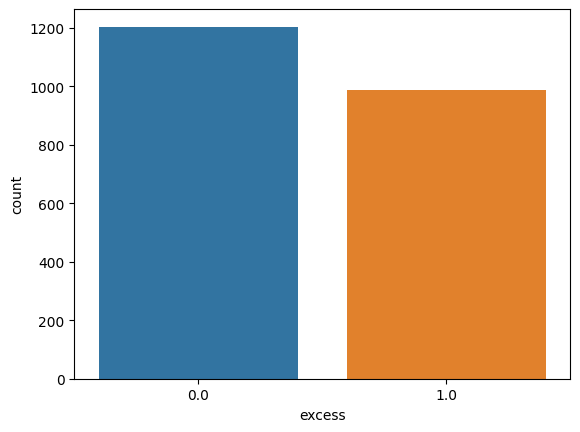

In [14]:
# 观察数据是否平衡
plot_class(y)

1.0    0.5
0.0    0.5
Name: excess, dtype: float64


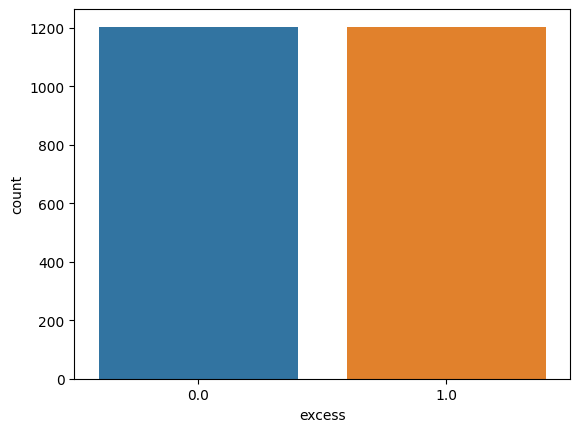

,close,low,amount,turn,volume,Target
0,4.74,4.74,117710.0,0.3866,248332.0,1.0
1,5.21,5.02,2207680.0,6.6873,4295680.0,0.0
2,4.90,4.86,1220570.0,3.7543,2411650.0,0.0
3,4.78,4.63,742832.0,2.4254,1558020.0,0.0
4,4.61,4.56,529849.0,1.7588,1129770.0,0.0
...,...,...,...,...,...,...
2403,2.79,2.79,1007330.0,2.2584,3555130.0,1.0
2404,1.55,1.51,660579.0,1.3594,4306110.0,1.0
2405,1.89,1.88,868959.0,1.4455,4578910.0,1.0
2406,1.08,1.07,199142.0,0.5819,1843380.0,1.0


In [15]:
# 数据平衡
selected_features_mod, label = Imbalance_sample(selected_features,y,'RandomOverSampler')
plot_class(label)
# 重新拼接
df = pd.concat([selected_features_mod, label.rename('Target')], axis=1)
df

In [16]:
#划分训练集和验证集
Train, Test = split_data(df, 0.3)

# 分离特征和标签
X_train, X_test, Y_train, Y_test = Split_XY(Train, Test)

# 因子标准化
X_train,X_test,scaler = Scaler_data(X_train, X_test,'MinMaxScaler')

## step 4: 模型训练

/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

         0.0       0.37      0.98      0.54       265
         1.0       0.77      0.04      0.08       458

    accuracy                           0.39       723
   macro avg       0.57      0.51      0.31       723
weighted avg       0.62      0.39      0.25       723

accuracy_score:  0.38589211618257263


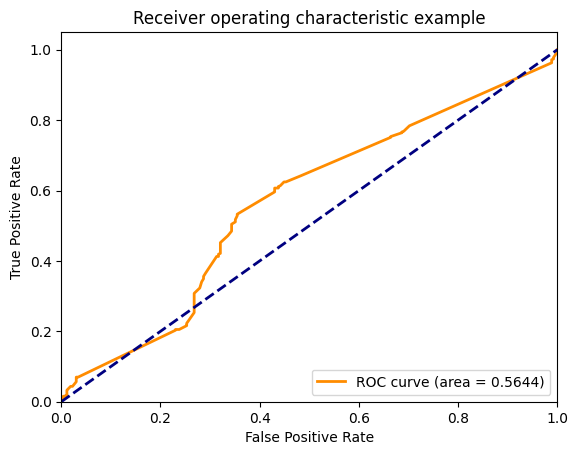

confusion_matrix:  [[259   6]
 [438  20]]


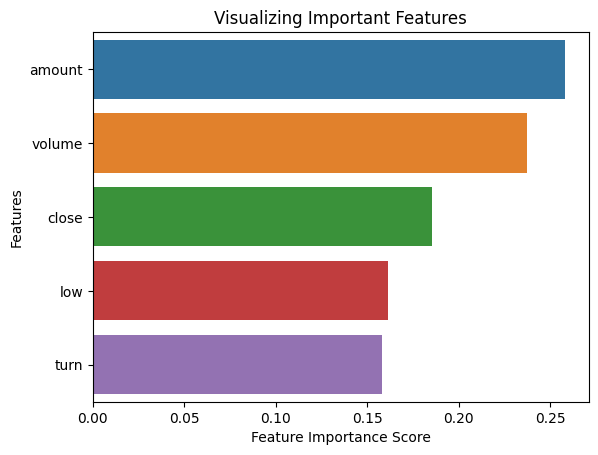

In [17]:
model = RandomForest_model(X_train, Y_train, X_test, Y_test)
Y_pred,Y_scores,best_model = model.RandomForest()
model.RandomForest_performance(Y_pred,Y_scores)
model.RandomForest_confusion_matrix(Y_pred)
model.RandomForest_importance(best_model)

## step 5: 样本外测试

In [85]:
test_out = get_price(ts_code_list = ['600010.SH'], feature_list=['open','close','low','high','avg_price','adj_close','amount','volume','turn'], start_date = '20230101', trade_date = '20230810', is_index = False, is_fund = False)
test_out = test_out.reset_index()
test_out.sort_values('trade_date', inplace = True)

# 选取一个基准
bench_out = get_price(ts_code_list = ['000016.SH'], feature_list = ['close'], start_date = '20230101', trade_date = '20230810', is_index = True, is_fund=False)
bench_out.reset_index(inplace=True)
bench_out.sort_values('trade_date', inplace=True)

In [86]:
# 计算每日超额收益率
daily_returns_out = test_out['close'].pct_change()
benchmark_returns_out = bench_out['close'].pct_change()
excess_returns_out = daily_returns_out - benchmark_returns_out

In [87]:
# 将超额收益转换为二分类问题
excess_returns_out = excess_returns_out.apply(lambda x: 1 if x > 0 else 0)
excess_returns_out = excess_returns_out.shift(-1)

In [88]:
# 表格拼接，删除最后一行
result_out = pd.concat([test_out, excess_returns_out.rename('excess')], axis=1)
result_out = result_out.drop(result_out.index[-1])
result_out

,trade_date,ts_code,open,close,low,high,avg_price,adj_close,amount,volume,turn,excess
0,2023-01-03,600010.SH,1.92,1.93,1.91,1.95,1.9330,16.21,380977.0,1970910.0,0.6222,1.0
1,2023-01-04,600010.SH,1.94,1.94,1.93,1.95,1.9402,16.30,353128.0,1820050.0,0.5746,0.0
2,2023-01-05,600010.SH,1.95,1.93,1.93,1.95,1.9379,16.21,256569.0,1323960.0,0.4180,0.0
3,2023-01-06,600010.SH,1.94,1.93,1.93,1.95,1.9384,16.21,281108.0,1450170.0,0.4578,0.0
4,2023-01-09,600010.SH,1.94,1.95,1.93,1.97,1.9443,16.38,681344.0,3504300.0,1.1063,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
141,2023-08-03,600010.SH,1.91,1.92,1.90,1.93,1.9150,16.13,532810.0,2782260.0,0.8833,0.0
142,2023-08-04,600010.SH,1.94,1.91,1.90,1.95,1.9258,16.04,478058.0,2482330.0,0.7881,1.0
143,2023-08-07,600010.SH,1.91,1.90,1.89,1.92,1.9059,15.96,359485.0,1886190.0,0.5988,0.0
144,2023-08-08,600010.SH,1.90,1.89,1.88,1.91,1.8939,15.88,338075.0,1785040.0,0.5667,1.0


In [101]:
X = result_out.iloc[:, 2:-1]

label = result_out.iloc[:, -1]
selected_features = X.iloc[:, top_k_indices]  # 提取选中的特征数据

selected_features
label

0      1.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
141    0.0
142    1.0
143    0.0
144    1.0
145    0.0
Name: excess, Length: 146, dtype: float64

In [102]:
X = selected_features
y = label
X
# 因子标准化
# from sklearn.preprocessing import StandardScaler
columns = X.columns
scaler = StandardScaler().fit(X)
X = pd.DataFrame(scaler.transform(X),columns= columns,index = list(X.index))
X

,close,low,amount,turn,volume
0,0.339147,0.295702,-0.161841,-0.180105,-0.176528
1,0.452714,0.530974,-0.272146,-0.301558,-0.298282
2,0.339147,0.530974,-0.654601,-0.701131,-0.698660
3,0.339147,0.530974,-0.557406,-0.599579,-0.596800
4,0.566281,0.530974,1.027865,1.055101,1.061019
...,...,...,...,...,...
141,0.225579,0.178066,0.439545,0.486105,0.478285
142,0.112012,0.178066,0.222681,0.243198,0.236221
143,-0.001556,0.060429,-0.246967,-0.239811,-0.244903
144,-0.115123,-0.057207,-0.331769,-0.321716,-0.326538


In [103]:
y_pred = best_model.predict(X)
y_pred_pro = best_model.predict_proba(X)
y_scores = pd.DataFrame(y_pred_pro, columns=best_model.classes_.tolist())[1].values

              precision    recall  f1-score   support

         0.0       0.55      0.41      0.47        82
         1.0       0.43      0.56      0.49        64

    accuracy                           0.48       146
   macro avg       0.49      0.49      0.48       146
weighted avg       0.50      0.48      0.48       146

accuracy_score:  0.4794520547945205


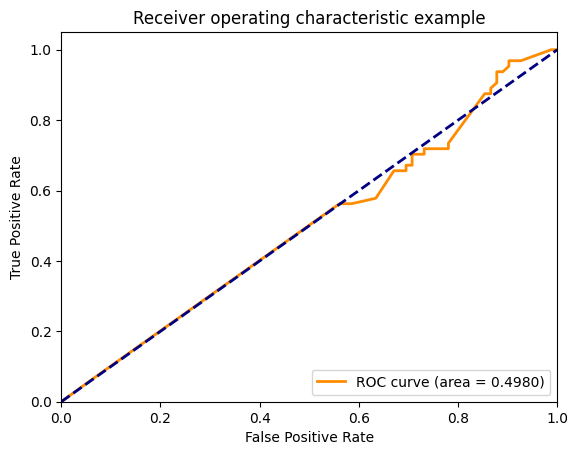

In [104]:
print(classification_report(y,y_pred))
print('accuracy_score: ',accuracy_score(y, y_pred))

auc_value = roc_auc_score(y, y_scores)

fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label=1.0)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', linewidth=lw, label='ROC curve (area = %0.4f)' % auc_value)
plt.plot([0, 1], [0, 1], color='navy', linewidth=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [131]:
# 这里不能用标准化的数据 X，而是要用原来的数据result_out来做
start_date = '20230101'
end_date = '20230810'
capital = 100000
shares = 0
portfolio = [capital]

for i in range(len(y_pred)):
    if y_pred[i] == 1:  # 预测为涨，买入股票
        close_price = result_out['adj_close'][i]  # 获取当天收盘价
        shares_to_buy = capital // close_price  # 计算可购买的股份数量（向下取整）
        capital -= shares_to_buy * close_price  # 扣除购买所需资金
        shares += shares_to_buy
        # print('买入',shares_to_buy,'目前',shares)

    elif y_pred[i] == 0:  # 预测为跌，卖出股票
        close_price = result_out['adj_close'][i]   # 获取当天收盘价 
        capital += shares * close_price   # 增加卖出所得资金 
        # print('卖出',shares)
        shares = 0
        
    close_price = result_out['adj_close'][i] 
    portfolio.append(capital+shares*close_price )

        

final_value = capital + (shares*result_out.iloc[-1,:]['adj_close'])

print("最终市值：", final_value)

最终市值： 97933.26000000001


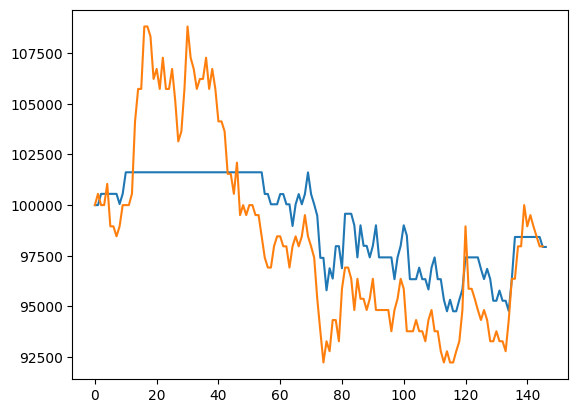

In [141]:
plt.plot(portfolio)
plt.plot(list(result_out['adj_close']*100000//result_out['adj_close'].iloc[0]+1))


In [78]:
def stock_strategy(initial_capital, start_date, end_date, y_pred, X):
    # 初始化初始资金和股票持仓数量
    capital = initial_capital
    shares = 0
    
    # 遍历每个交易日进行买入1或卖出0操作
    for i in range(len(y_pred)):
        if y_pred[i] == 1:  # 预测为涨，买入股票
            close_price = X['adj_close'][i]  # 获取当天收盘价
            shares_to_buy = capital // close_price  # 计算可购买的股份数量（向下取整）
            capital -= shares_to_buy * close_price  # 扣除购买所需资金
            shares += shares_to_buy

        elif y_pred[i] == 0:  # 预测为跌，卖出股票
            close_price = X['adj_close'][i]   # 获取当天收盘价 
            capital += shares * close_price   # 增加卖出所得资金 
            shares = 0

    final_value = capital + (shares*X.iloc[-1,:]['adj_close'])

    # 返回最终市值 
    return final_value

In [90]:
def feature_selection(result, top_k_indices):
    """
    对给定的DataFrame进行特征选择和数据平衡处理，并返回处理后的DataFrame。
    
    参数：
    result (pd.DataFrame): 包含因子矩阵和超额收益率的DataFrame。
    k (int): 要选择的前k个特征数量，默认为5。
    
    返回：
    df (pd.DataFrame): 处理后的DataFrame，包含选中的特征和平衡后的标签列。
    """
    X = result.iloc[:, 2:-1]
    y = result.iloc[:, -1]
    selected_features = X.iloc[:, top_k_indices]  # 提取选中的特征数据
    
    
    # 重新拼接
    df = pd.concat([selected_features_mod, y.rename('Target')], axis=1)
    return df

In [2]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, \
                            accuracy_score,\
                            classification_report,\
                            roc_curve,roc_auc_score  # 引入预测准确度评分函数
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit  # 网格搜索参数调优函数
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

def Imbalance_sample(X, Y, type):
    """
    如果是做分类问题，需要考虑数据是否balanced
    :param X:
    :param Y:
    :param type:
    :return:
    """
    if type == 'RandomOverSampler':
        ros = RandomOverSampler(random_state=42)
        X_resampled, Y_resampled = ros.fit_resample(X, Y)
    elif type == 'RandomUnderSampler':
        rus = RandomUnderSampler(random_state=42)
        X_resampled, Y_resampled = rus.fit_resample(X, Y)
    elif type == 'Smote':
        smo = SMOTE(random_state=42)
        X_resampled, Y_resampled = smo.fit_resample(X, Y)

    return X_resampled, Y_resampled

def plot_class(data):
    '''
    用于直观观察数据是否平衡
    '''
    print(data.value_counts(normalize=True))
    sns.countplot(data)
    plt.show()
    
def MAD(series, n):
    """
    中位数 MAD去极值
    :param series:
    :param n:
    :return:
    """
    median = series.quantile(0.5)  # 获取中位数
    diff_median = ((series - median).abs()).quantile(0.5)  # 获取MAD，绝对偏差的中位数
    max_range = median + n * diff_median
    min_range = median - n * diff_median
    return np.clip(series, min_range, max_range)

def Scaler_data(Train, Test, type):
    """
    数据处理
    :param Train:
    :param Test:
    :param type:
    :return:
    """
    if type == 'StandardScaler':
        # from sklearn.preprocessing import StandardScaler
        columns = Train.columns
        scaler = StandardScaler().fit(Train)
        Train = pd.DataFrame(scaler.transform(Train),columns= columns,index = list(Train.index))
        Test = pd.DataFrame(scaler.transform(Test),columns= columns,index = list(Test.index))

    elif type == 'Normalize':
        # from sklearn.preprocessing import Normalizer
        columns = Train.columns
        scaler = Normalizer().fit(Train)
        Train = pd.DataFrame(scaler.transform(Train),columns= columns,index = list(Train.index))
        Test = pd.DataFrame(scaler.transform(Test),columns= columns,index = list(Test.index))
    elif type == 'MinMaxScaler':
        # from sklearn.preprocessing import MinMaxScaler
        columns = Train.columns
        scaler = MinMaxScaler().fit(Train)
        Train = pd.DataFrame(scaler.transform(Train),columns= columns,index = list(Train.index))
        Test = pd.DataFrame(scaler.transform(Test),columns= columns,index = list(Test.index))
    else:
        raise TypeError('Type must be StandardScaler, Normalizer,MinMaxScaler')
    return Train, Test, scaler

def Inverse_data(data, scaler):
    """
    恢复数据
    :param data:
    :param scaler:
    :return:
    """
    data = scaler.inverse_transform(data)
    return data

In [3]:
def split_data(data, ratio):
    """
    划分训练集测试集
    :param data:
    :param ratio:
    :return:
    """
    Train, Test = train_test_split(data, test_size=ratio, random_state=42,shuffle=False)
    return Train, Test

def Split_XY(Train,Test):
    X_train = Train.iloc[:,:-1]
    Y_train = Train.iloc[:, -1:]

    X_test = Test.iloc[:, :-1]
    Y_test = Test.iloc[:, -1:]

    return X_train,X_test,Y_train,Y_test

In [4]:
class RandomForest_model():
    def __init__(self,X_train,Y_train,X_test,Y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test

    def RandomForest(self):
        """n_estimators参数的候选值范围为{5，10，20}，max_depth参数的候选值范围为{2，3，4，5}，
        min_samples_leaf参数的候选值范围为{5，10，20，30}。"""
        parameters = {'n_estimators': [5, 10], 'max_depth': [2, 3], "criterion": ["gini", "entropy"],'min_samples_leaf': [10, 20]}
        time_split = TimeSeriesSplit(n_splits=10)
        new_rfc = RandomForestClassifier(random_state=42)  # 构建的随机森林模型

        """设置cv参数为6，表示交叉验证6次；设置模型评估标准scoring参数为'accuracy'，即以准确度作为评估标准，
        如果设置成'roc_auc'则表示以ROC曲线的AUC值作为评估标准。"""

        grid_search = GridSearchCV(new_rfc, parameters, cv=time_split, scoring='roc_auc')

        grid_search.fit(self.X_train, self.Y_train.values.ravel())
        best_para = grid_search.best_params_
        best_model = grid_search.best_estimator_
        best_model.fit(self.X_train, self.Y_train)
        Y_pred = best_model.predict(self.X_test)
        Y_pred_pro = best_model.predict_proba(self.X_test)
        Y_scores = pd.DataFrame(Y_pred_pro, columns=best_model.classes_.tolist())[1].values


        return Y_pred,Y_scores,best_model
    
    def RandomForest_performance(self,Y_pred,Y_scores):
        print(classification_report(self.Y_test,Y_pred))
        print('accuracy_score: ',accuracy_score(self.Y_test,Y_pred))

        auc_value = roc_auc_score(self.Y_test, Y_scores)

        fpr, tpr, thresholds = roc_curve(self.Y_test, Y_scores, pos_label=1.0)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', linewidth=lw, label='ROC curve (area = %0.4f)' % auc_value)
        plt.plot([0, 1], [0, 1], color='navy', linewidth=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

    def RandomForest_confusion_matrix(self,Y_pred):
        matrix = confusion_matrix(self.Y_test, Y_pred)
        print('confusion_matrix: ', matrix)

    def RandomForest_importance(self,model):
        features = self.X_train.columns
        importances = model.feature_importances_
        Imp_score = pd.DataFrame()
        Imp_score['特征'] = features
        Imp_score['特征重要性'] = importances
        Imp_score = Imp_score.sort_values('特征重要性', ascending=False)
        sns.barplot(x=Imp_score['特征重要性'], y=Imp_score['特征'])

        # Add labels to the graph

        plt.xlabel('Feature Importance Score')

        plt.ylabel('Features')

        # Add title to the graph

        plt.title("Visualizing Important Features")

        # Visualize the graph

        plt.show()